# <center>Torrance Learning eLearning User Data Analysis</center>
<center> UMich Portlab - Excerpt of Project Components Created by Riddhisha Prabu </center>

## <center> Executive Summary</center> 

### Problem Statement:
Torrance Learning (TL) is vendor providing elearning training courses and webinars to a variety of clients. TL also provides learning content to students and professionals at the American Spinal Injury Association (ASIA). For this project TL, would like to obtain more information on the the course taking patterns for ASIA users.

### Observations Summary: 
The sample data provided by TL is a snapshot from ~ Nov 2019 to June 2022 and consists of ASIA professional users to Student users in the ration ~3:1. Based on an exploratory analysis of sample data, the following observations can be made: 

(1) <b> Number of Courses per User </b>: Most Professionals take ~1 course each while Students take closer to 2 courses. (See Fig. 1)

(2) <b> Course Popularity </b>: Torrance Learning's flagship InStep (International Standards 2019) course appears to be the most popular amongst students and professionals alike. This is followed by AStep (Autonomic Anatomy & Function) which appears more popular amongst professionals. (See Fig. 2)

(3) <b> Initial Courses and Continuing Training </b>: (See Fig. 3)
  * 65% of Professionals start with InStep. Of these, a majority (~80%) do not continue and ~16% continue with AStep
  * Students either start with either InStep (51%) or AStep (48%) 
    * 62% of the Students starting with InStep, do not continue. 31% take AStep next 
    * A majority of the Students starting with AStep continue with InStep (83%)

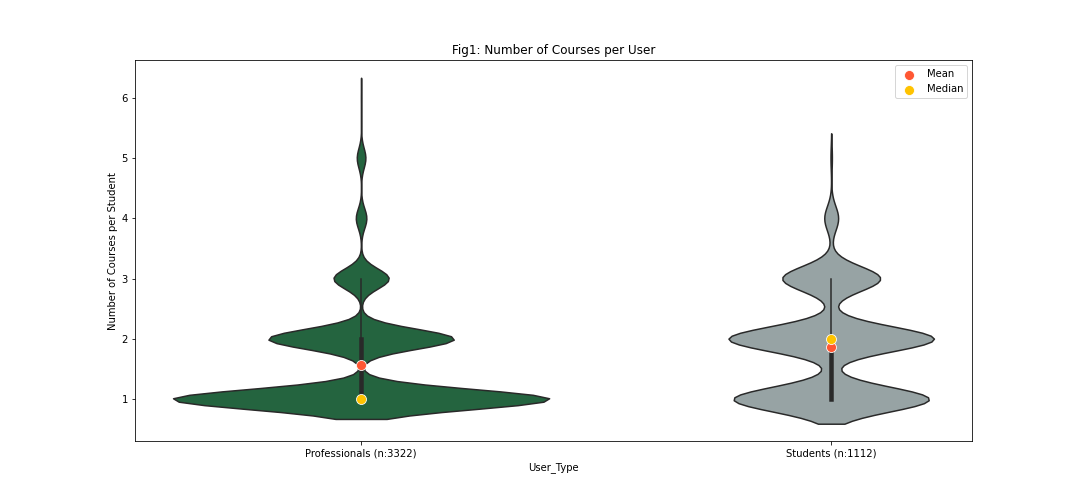

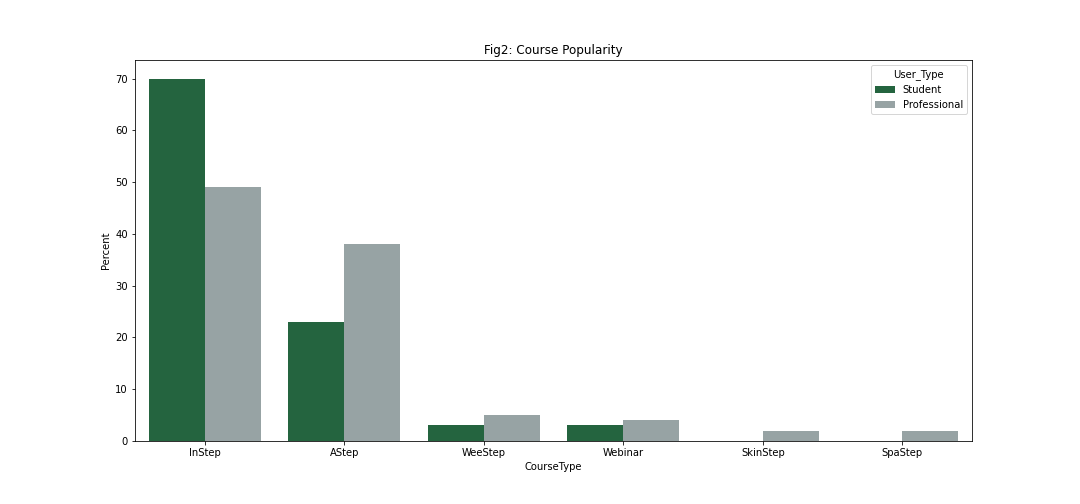

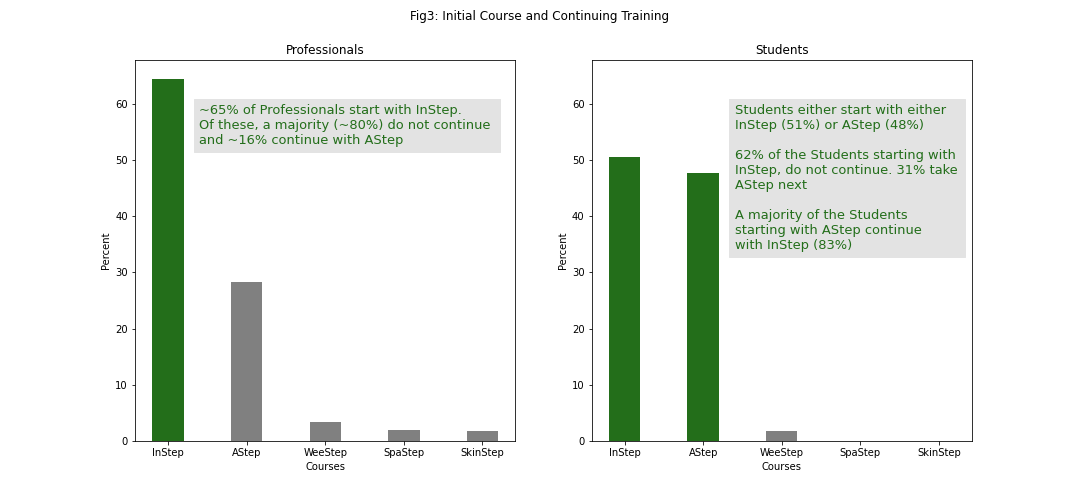

## <center> Project Code and Analysis Details </center>

### Data Loading & Preprocessing 

The client has provided data mainly in the form of two cvs files:

   <b> (1) Course Metadata </b>: as the name implies, this file contains metadata about each course, such as the courseID and the underlying modules within each course. Our analysis for this project is limited to the course level and not the underlying module level
   
   <b> (2) ASIA Master Data de-ID</b>: contains eLearning platform usage data for each user. This is the primary data for our analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

In [2]:
df_meta = pd.read_excel("Course Metadata.xlsx")
df_meta.head(2)
# df_meta.info()

,Course ID,Course,Type,Type2,Language
0,E-As-EN-001-1,ASTeP Part 1 - Autonomic Anatomy & Function(87...,Elearning,Module,English
1,E-As-EN-001-1,ASTeP: Autonomic Anatomy & Function(875005),Elearning,Module,English


In [3]:
df_asia = pd.read_excel("ASIA Master Data de-ID.xlsx")
df_asia.head(2)
# df_asia.info()

,UserID,User Domain,Enrollment Date,First Launch Date,Status,Completion Date,Price,Time (in Hours),Score,Course,Column11,GroupByColumn1,GroupByColumn3,Provider,Media,Category
0,A002223,ASIA User,2019-11-12 14:50:34,2021-10-08,Complete,2021-10-08 12:08:22,50,0.0,0,InSTeP: International Standards 2019(874713),NaN,InSTeP: International Standards 2019,NaN,ASIA,Certificate with CME,(none)
1,A004695,ASIA User,2019-11-12 14:50:34,2019-11-27,Complete,2019-11-27 12:34:00,50,0.0,0,InSTeP: International Standards 2019(874713),NaN,InSTeP: International Standards 2019,NaN,ASIA,Certificate with CME,(none)


### Data Transformation: 

Per discussions with the client:

    (1) dropping rows with no UserID
    (2) dropping those courses that were never launched
    (3) adding a columns to identify student as "User Domain" == "Bulk Upload Instep" [def categorize(x)]
    (4) adding Pre/Pandemic/Post information per First Launch Date [def period(x)]
    (5) dropping columns with blanks/non useful information

The next few functions append the data with markers based on the info shared by the client:

    (6) adding information on coursetype [def course_type(x)]
    (7) excluding surveys per discussion with the client
    

Note also that both "ASIA" and "Steel Assembly" providers should be included in our analysis per the client; (Steel Assembly is the sponsor and for the purposes of this analysis, they should be treated the same).

In [4]:
## (1 and 2)
# df_asia["UserID"].unique().shape                                                     ## 4978 unique users
# df_asia[df_asia["First Launch Date"].isnull()].shape                                 ## ~6500 never lauched the course 
df_asia.dropna(axis = 0, subset = ["UserID","First Launch Date"], inplace = True)      ## (1 and 2)  




## (3) student vs professional
def categorize(x):
    if x =="Bulk Upload Instep": 
        return "Student"
    else: return "Professional"
    

    
    
## (4) Pre-pandemic is before Mar 1, 2020; Pandemic is March 1 - Dec 31, 2021; and Post is Jan 1,2022 – through current)
def period(x):
    if x < pd.to_datetime('03/01/2020'):
        return "Pre-pandemic"
    elif x>= pd.to_datetime('03/01/2020') and x <= pd.to_datetime('12/31/2021'):
        return "Pandemic"
    else: return "Post-pandemic"


df_asia["User_Type"] = df_asia["User Domain"].apply(lambda x: categorize(x))            ## (3)
df_asia["Period"] = df_asia["First Launch Date"].apply(lambda x: period(x))             ## (4)    



##(5)
df_asia.drop(["Column11","GroupByColumn1","GroupByColumn3","Category","User Domain",
"Enrollment Date","Score","Provider","Media"], axis = 1, inplace = True)                ## (5)


df_asia.sort_values("First Launch Date", inplace = True)
df_asia.head(3)

,UserID,First Launch Date,Status,Completion Date,Price,Time (in Hours),Course,User_Type,Period
5215,A002223,2019-11-13,Waived,NaT,0,0.000000,InSTeP Module 1 - Basic Anatomy(874714),Professional,Pre-pandemic
5210,A002063,2019-11-15,Complete,2019-11-18 10:10:37,0,1.383333,InSTeP Module 1 - Basic Anatomy(874714),Professional,Pre-pandemic
5205,A003198,2019-11-18,Complete,2019-11-18 23:26:47,0,0.166666,InSTeP Module 1 - Basic Anatomy(874714),Professional,Pre-pandemic


In [5]:
##merging both datasets
merged_df = pd.merge(df_asia,df_meta, how="left", left_on="Course", right_on="Course")
merged_df.head()
# merged_df.shape

,UserID,First Launch Date,Status,Completion Date,Price,Time (in Hours),Course,User_Type,Period,Course ID,Type,Type2,Language
0,A002223,2019-11-13,Waived,NaT,0,0.000000,InSTeP Module 1 - Basic Anatomy(874714),Professional,Pre-pandemic,E-In-EN-001-1,Elearning,Module,English
1,A002063,2019-11-15,Complete,2019-11-18 10:10:37,0,1.383333,InSTeP Module 1 - Basic Anatomy(874714),Professional,Pre-pandemic,E-In-EN-001-1,Elearning,Module,English
2,A003198,2019-11-18,Complete,2019-11-18 23:26:47,0,0.166666,InSTeP Module 1 - Basic Anatomy(874714),Professional,Pre-pandemic,E-In-EN-001-1,Elearning,Module,English
3,A003198,2019-11-18,Incomplete,NaT,0,0.450000,InSTeP Module 4 - Anorectal Exam(874720),Professional,Pre-pandemic,E-In-EN-001-4,Elearning,Module,English
4,A002063,2019-11-18,Complete,2019-11-18 14:15:04,0,3.666666,InSTeP Module 3 - Motor Exam(874717),Professional,Pre-pandemic,E-In-EN-001-3,Elearning,Module,English


In [6]:
## (5 and 6) course_type original
def course_type(x):
    courses = {"E-As":"AStep",
               "E-In":"InStep",
               "E-Sk":"SkinStep", 
               "E-SP":"SpaStep",
               "E-We":"WeeStep",
               "W-EN":"Webinar", 
               "W-SP":"Webinar", #Treating Spanish and English webinars the same
               "E-SU":"Survey",   
               "W-SU":"Survey"}     
    return courses[x[0:4]]
    
merged_df["CourseType"] = merged_df["Course ID"].apply(lambda x:course_type(x))       #(5)
merged_df = merged_df[merged_df["CourseType"]!= "Survey"]
# merged_df.shape

merged_df.head()

,UserID,First Launch Date,Status,Completion Date,Price,Time (in Hours),Course,User_Type,Period,Course ID,Type,Type2,Language,CourseType
0,A002223,2019-11-13,Waived,NaT,0,0.000000,InSTeP Module 1 - Basic Anatomy(874714),Professional,Pre-pandemic,E-In-EN-001-1,Elearning,Module,English,InStep
1,A002063,2019-11-15,Complete,2019-11-18 10:10:37,0,1.383333,InSTeP Module 1 - Basic Anatomy(874714),Professional,Pre-pandemic,E-In-EN-001-1,Elearning,Module,English,InStep
2,A003198,2019-11-18,Complete,2019-11-18 23:26:47,0,0.166666,InSTeP Module 1 - Basic Anatomy(874714),Professional,Pre-pandemic,E-In-EN-001-1,Elearning,Module,English,InStep
3,A003198,2019-11-18,Incomplete,NaT,0,0.450000,InSTeP Module 4 - Anorectal Exam(874720),Professional,Pre-pandemic,E-In-EN-001-4,Elearning,Module,English,InStep
4,A002063,2019-11-18,Complete,2019-11-18 14:15:04,0,3.666666,InSTeP Module 3 - Motor Exam(874717),Professional,Pre-pandemic,E-In-EN-001-3,Elearning,Module,English,InStep


### Analysis 1: How many courses do users take?

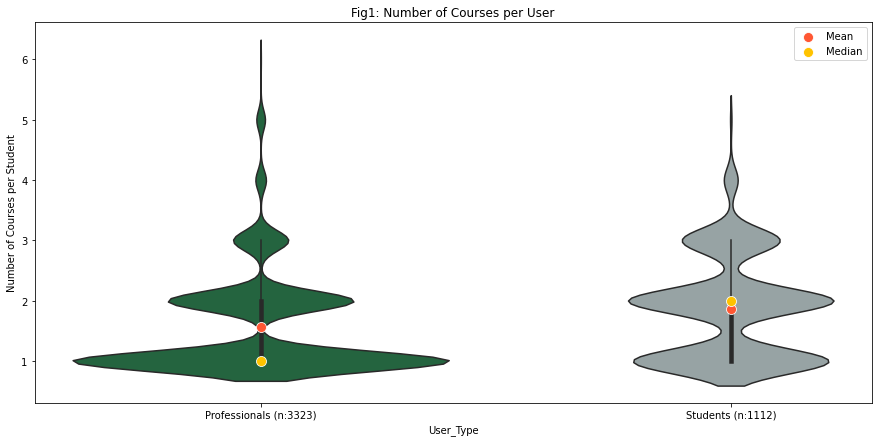

In [7]:
# merged_df.shape  #17430
_ = merged_df[["User_Type","UserID","CourseType"]].drop_duplicates()                ##7303 unique 
# _.shape
# _.head()

__ = _.groupby(["User_Type","UserID"]).agg({"CourseType":len}).reset_index()      ##__ contains number of courses per student
__.shape                                                                        ##4435
__.head()


plt.figure(figsize = (15,7));
colors = ["#196F3D","#95A5A6"]
sns.violinplot(data = __, x= "User_Type", y = "CourseType", palette = colors).set_title("Fig1: Number of Courses per User");

p_count = __[__["User_Type"] == "Professional"].shape[0]
s_count = __[__["User_Type"] == "Student"].shape[0]
p_mean = float(__[__["User_Type"] == "Professional"].mean().round(2))
p_median = float(__[__["User_Type"] == "Professional"].median().round(2))
s_mean = float(__[__["User_Type"] == "Student"].mean().round(2))
s_median = float(__[__["User_Type"] == "Student"].median().round(2))

sns.scatterplot([0,1],[p_mean, s_mean], zorder = 3, s=100, color = "#FF5733", marker="o", label = "Mean");
sns.scatterplot([0,1],[p_median, s_median], zorder = 3, s=100, color="#FFC300", marker="o", label = "Median");
plt.ylabel("Number of Courses per Student");
plt.gca().set_xticklabels([("Professionals (n:"+str(p_count)+")"),("Students (n:"+str(s_count)+")")])
plt.savefig("AverageCourse.png")

#### Observations: Most Professionals take ~1 course each while Students take closer to 2 courses

### Analysis 2: Which courses are most popular?

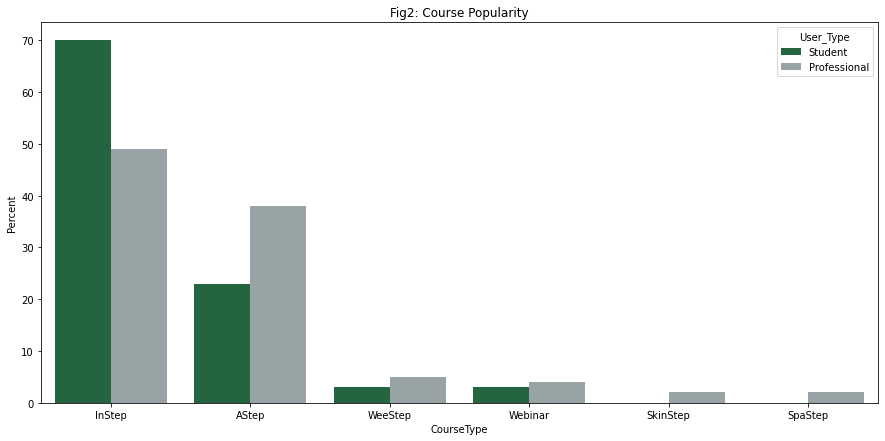

In [8]:
_ = (merged_df.groupby(["User_Type","CourseType"]).size() / merged_df.groupby(["User_Type"]).size()).round(2).reset_index()
_.rename(columns = {0:"Percent"}, inplace = True)
_.sort_values("Percent", ascending = False, inplace = True)
_.head()

plt.figure(figsize = (15,7))
colors = ["#196F3D","#95A5A6"]
sns.barplot(data =_, x = "CourseType", y = "Percent", hue = "User_Type", palette = colors).set_title("Fig2: Course Popularity");
plt.gca().set_yticklabels(np.arange(0,80,10));
plt.savefig("CoursePopularity.png")


#### Observation: Torrance Learning's flagship InStep (International Standards 2019) course appears to be the most popular amongst students and professionals alike. This is followed by AStep (Autonomic Anatomy & Function) which appears more popular amongst professionals.

### Analysis 3: Which course do Professionals/Students start with? How do they continue?

In [9]:
merged_df = merged_df[(merged_df["Status"] != "Not Started") & (merged_df["Status"] != "Waived")]
usertype = ["Professional","Student"]
# merged_df.columns

test = {}
for user in usertype:
    sub_df = merged_df[merged_df["User_Type"]==user]
    
   
    ##find first course:
    starts = {}      #absolute number of users starting with each course
    startsp = {}     #of users starting with each course

    
    ##we group by each studentID and we increase the counter(starts) based on the course this student started with
    for group, frame in sub_df.groupby("UserID"):
        frame.sort_values("First Launch Date", inplace = True)

        if frame.iloc[0,13] == "InStep":
            starts["InStep"] = starts.get("InStep",0) + 1 
        elif frame.iloc[0,13] == "AStep":
            starts["AStep"] = starts.get("AStep",0) + 1 
        elif frame.iloc[0,13] == "SpaStep":
            starts["SpaStep"] = starts.get("SpaStep",0) + 1 
        elif frame.iloc[0,13] == "SkinStep":
            starts["SkinStep"] = starts.get("SkinStep",0) + 1 
        elif frame.iloc[0,13] == "WeeStep":
            starts["WeeStep"] = starts.get("WeeStep",0) + 1 
    
#     print(starts) 
    total = 0
    for v in starts.values(): 
        total += v
    for k,v in starts.items():
        startsp[k] = round(v/total *100,2)
#     print(startsp)
    
    test[user] = startsp
    test_pd = pd.DataFrame(test)

test_pd

,Professional,Student
AStep,28.29,47.66
InStep,64.52,50.63
WeeStep,3.44,1.71
SkinStep,1.71,NaN
SpaStep,2.04,NaN


In [10]:
##find second course:
       ## (A) For professionals, since a majority of the users start with InSTep, for simplicity, we just check what course, if any, 
       ##users take after instep

       ## (B)For students, we check which course they move onto after starting (B1) AStep or (B2) InStep


##(A) Professional Users that start with Instep; what do they take next
sub_df = merged_df[merged_df["User_Type"]=="Professional"]

prof_next = {}
for group, frame in sub_df.groupby("UserID"):
    frame.sort_values("First Launch Date", inplace = True)
   
    if frame.iloc[0,13] == "InStep":
        temp = frame[frame["CourseType"] != "InStep"]
        if len(temp) == 0: 
            prof_next["None"] = prof_next.get("None",0) + 1
        elif temp.iloc[0,13] == "AStep":
            prof_next["AStep"] = prof_next.get("AStep",0) + 1 
        else:
            prof_next["Other"] = prof_next.get("Other",0) + 1 
        
# print(nextcourse)

prof_nextp = {}
total = 0
for v in prof_next.values(): 
    total += v
for k,v in prof_next.items():
    prof_nextp[k] = round(v/total *100,2)

prof_nextp

{'None': 79.94, 'AStep': 15.9, 'Other': 4.15}

In [11]:
##B
##(B) Student Users that start with (B1) ASTep and (B2) InStep; what do they take next
sub_df = merged_df[merged_df["User_Type"]=="Student"]

student_next_a = {}
student_next_i = {}
for group, frame in sub_df.groupby("UserID"):
    frame.sort_values("First Launch Date", inplace = True)
   
    ##(B1)
    if frame.iloc[0,13] == "AStep":
        temp = frame[frame["CourseType"] != "AStep"]
        if len(temp) == 0: 
            student_next_a["None"] = student_next_a.get("None",0) + 1
        elif temp.iloc[0,13] == "InStep":
            student_next_a["InStep"] = student_next_a.get("InStep",0) + 1 
        else: 
            student_next_a["Other"] = student_next_a.get("Other",0) + 1
            
    ##(B2)            
    elif frame.iloc[0,13] == "InStep":     
        temp = frame[frame["CourseType"] != "InStep"]
        if len(temp) == 0: 
            student_next_i["None"] = student_next_i.get("None",0) + 1
        elif temp.iloc[0,13] == "AStep":
            student_next_i["AStep"] = student_next_i.get("AStep",0) + 1 
        else: 
            student_next_i["Other"] = student_next_i.get("Other",0) + 1 
 
# print(student_next_a)
# print(student_next_i)


student_next_ap = {}
student_next_ip = {}


total = 0
for v in student_next_a.values(): 
    total += v
for k,v in student_next_a.items():
    student_next_ap[k] = round(v/total *100,2)

print("AStep starter students:")
print(student_next_ap)

total = 0
for v in student_next_i.values(): 
    total += v
for k,v in student_next_i.items():
    student_next_ip[k] = round(v/total *100,2)

print("InStep starter students:")
print(student_next_ip)

AStep starter students:
{'InStep': 82.8, 'None': 13.42, 'Other': 3.78}
InStep starter students:
{'AStep': 31.49, 'None': 62.1, 'Other': 6.41}


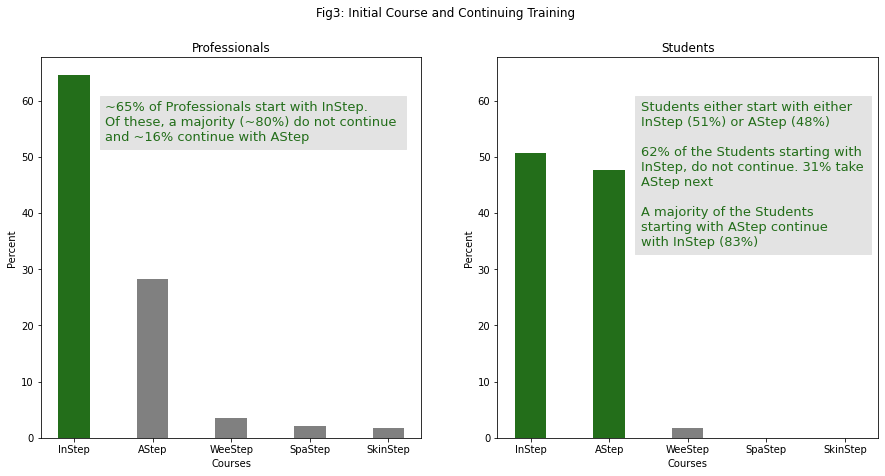

In [17]:
%matplotlib inline
plt.figure(figsize = (15,7));
# xlist = ["InSTeP","ASTeP","SkinSTeP","WeeSTep","SpAsTeP"]

test_pd.sort_values("Professional", ascending = False, inplace = True)
plt.subplot(1,2,1);
clrs1 = ['grey' if (x < np.max(test_pd["Professional"])) else '#236E1A' for x in test_pd["Professional"]];
plt.bar(x =  test_pd.index, height = test_pd["Professional"], width =0.4, color = clrs1);
# plt.grid(axis = "y", alpha =0.2);
# plt.tick_params(axis='both');
plt.xlabel("Courses");
plt.ylabel("Percent");
plt.title("Professionals");

##Text is based on prof_nextp
plt.text(x =  0.4, y = 60, s = """~65% of Professionals start with InStep. 
Of these, a majority (~80%) do not continue 
and ~16% continue with AStep""", 
va = "top", backgroundcolor = "#E3E3E3", color = "#236E1A", fontsize = 13);



test_pd.sort_values("Student", ascending = False, inplace = True)
plt.subplot(1,2,2, sharey = plt.subplot(1,2,1), sharex = plt.subplot(1,2,1));
clrs2 = ['grey' if x < float(40) else '#236E1A' for x in test_pd["Student"]];
plt.bar(x = test_pd.index, height = test_pd["Student"], width =0.4, color = clrs2);
# plt.grid(axis = "y", alpha =0.2);
# plt.tick_params(axis='both', labelsize=10, color = "grey");
plt.xlabel("Courses");
plt.ylabel("Percent");
plt.title("Students");

##Text is based on student_next_ap & student_next_ip
plt.text(x = 1.4 ,y = 60, s = """Students either start with either 
InStep (51%) or AStep (48%)

62% of the Students starting with 
InStep, do not continue. 31% take
AStep next

A majority of the Students
starting with AStep continue
with InStep (83%)""",va = "top", backgroundcolor = "#E3E3E3", color = "#236E1A", fontsize = 13);

plt.suptitle("Fig3: Initial Course and Continuing Training");
plt.savefig("InitialandContinuing.png")

# plt.show()

#### Observation: 65% of Professionals start with InStep. Of these, a majority (~80%) do not continue and ~16% continue with AStep. Students either start with either InStep (51%) or AStep (48%) . 62% of the Students starting with InStep, do not continue. 31% take AStep next. A majority of the Students starting with AStep continue with InStep (83%)